# ISE 633 Homework 5

Author: Yue Wu <wu.yue@usc.edu>
$\def\vf#1{\boldsymbol{#1}}$

This notebook is the coding part of the 5th homework of ISE 633. It is written in a style where code and explanations are interleaved. The notebook is written in Python 3.12 and is best viewed in a Jupyter notebook environment.

### Dependencies

It requires the following packages:

```plain
jax==0.4.25
jaxtyping==0.2.25
beartype==0.17.2
equinox==0.11.3
```

and reasonably new versions of `ipytest`, `seaborn`, `matplotlib` and `pandas`. The notebook is exclusively written in Python 3.12+. Since the computation is done with JAX with its fully deterministic RNGs, the results should be completely reproducible. The local dependencies (i.e. `utils.*`) will be available in the same directory as this notebook in my github [repository](https://github.com/EtaoinWu/ise633).

A significant portion of code in this notebook is identical to my previous homeworks.

In [1]:
from functools import partial

import beartype
import equinox as eqx
import ipytest
import jax
import jax.scipy.optimize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from beartype.typing import Any, Callable, cast
from jax import numpy as jnp, random as jr, tree_util as jtu
from jaxtyping import Array, Bool, Float, Integer, Key, Scalar, jaxtyped
from matplotlib.axes import Axes
import tqdm.notebook as tqdm

import utils.platform
from utils.tree import tree_nfold_cross_validation_tests, tree_nfold_cross_validation_trains, tree_unstack

ipytest.autoconfig()
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_threefry_partitionable", True)

utils.platform.init_matplotlib("svg")
sns.set_theme("notebook", style="whitegrid")

SingleKey = Key[Scalar, ""]
typechecked = jaxtyped(typechecker=beartype.beartype)
FloatLike = float | Float[Scalar, ""]

We first define our model.

In [2]:
class PartitionProblem(eqx.Module):
    n: int = eqx.field(static=True)
    l: Float[Scalar, ""]
    a: Float[Array, "n n"]
    def __check_init__(self):
        assert self.a.shape == (self.n, self.n)
        assert jnp.all(jnp.equal(self.a, self.a.T))

    @property
    def a_tilde(self) -> Float[Array, "n n"]:
        return jnp.ones_like(self.a) * self.l - self.a

@typechecked
def load_partition(fn: str) -> PartitionProblem:
    a_np = np.loadtxt("hw5/A.txt",dtype=float,delimiter=",")
    a = jnp.array(a_np)
    return PartitionProblem(n=a.shape[0], l=jnp.array(5.), a=a)

In [3]:
cur_partition = load_partition("hw5/A.txt")
print(f"Symmetric: {jnp.allclose(cur_partition.a, cur_partition.a.T)}")

Symmetric: True


### Visualization of the matrix


In [4]:
def visualize_matrix(a: Float[Array, "n n"], title: str | None = None) -> plt.Figure:
    fig, ax = plt.subplots()
    ax = cast(Axes, ax)
    sns.heatmap(a, ax=ax, square=True, cmap=["#ffffee", "black"], cbar=False, xticklabels=False, yticklabels=False)
    ax.set_title(title if title else "Matrix")
    return fig

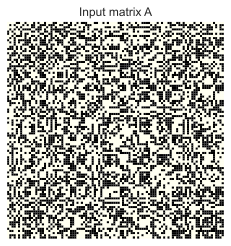

In [5]:
plt.ioff()
fig = visualize_matrix(cur_partition.a, title="Input matrix A")
fig

## Reformulation

We introduce another variable ${Z}$ to decouple the constraint on the diagonal and the PSD constraint. In the below problem

$$
\begin{array}{rl}
\min\limits_{X,Z} &\langle X,\tilde{A}\rangle \\
\textrm{s.t. } & X \succeq 0\\
&Z_{ii}=1, \forall i\in \{1, \dots, n\}\\
&Z=X
\end{array}
$$

we can see that the feasibility condition on $X$ and the objective function is the same as the original.

## Rewrite the problem for solving with ADMM

With $\lambda=5$, we have:

In [6]:
a_tilde = cur_partition.a_tilde

We can further rewrite the problem for better computation with ADMM. The augmented Lagrangrian function is

$$
\begin{align*}
\mathcal{L}(X,Z,\vf \eta,M)
={}&
\langle X,\tilde A\rangle\\
&{}+\langle M, Z-X\rangle\\
&{}+\vf \eta^T (\operatorname{diag}Z-\vf 1)\\
&{}+{\rho\over 2}\left(\left\|\operatorname{diag}Z-\vf 1\right\|^2+\left\|Z-X\right\|^2\right)
\end{align*}
$$

To compute ADMM, we need to minimize $\mathcal{L}$ with respect to $X$ and $Z$.

Minimizing w.r.t $X$ gives 

$$\begin{array}{rl}
\min\limits_{X}&\langle X,\tilde A-M\rangle+{\rho\over 2}\left\|Z-X\right\|^2 \\
\text{s.t.}&X\succeq 0
\end{array}
$$

The objective function can be rewritten as ${\rho\over 2}\left\|Z+{1\over \rho}(M-\tilde A)-X\right\|^2$ plus some constant, so the optimal $X^*$ is equal to the projection of $Z+{1\over \rho}(M-\tilde A)$ to the semidefinite cone.

Minimizing w.r.t $Z$ gives 

$$\begin{array}{rl}
\min\limits_{Z}&\langle M, Z\rangle + \langle\vf\eta,\operatorname{diag} Z\rangle+{\rho\over 2}\left(\left\|\operatorname{diag}Z-\vf 1\right\|^2+\left\|Z-X\right\|^2\right)
\end{array}
$$

Using the first order condition, if $i\neq j$, we have $M_{ij}+\rho(Z^*_{ij}-X_{ij})=0$ which solves to $Z^*_{ij}=X_{ij}-\frac 1 \rho M_{ij}$; and for the diagonal entries, $M_{ii}+\eta_i+\rho(Z^*_{ii}-1+Z^*_{ii}-X_{ii})=0$, which implies $Z^*_{ii} = \frac 12 (X_{ii} + 1) - \frac 1{2\rho} (M_{ii}+\eta_i)$.

In [7]:
class ADMMState(eqx.Module):
    x: Float[Array, "n n"]
    z: Float[Array, "n n"]
    m: Float[Array, "n n"]
    eta: Float[Array, " n"]

In [8]:
class AugmentedPartition(eqx.Module):
    n: int = eqx.field(static=True)
    a: Float[Array, "n n"]
    rho: Float[Scalar, ""]

    @typechecked
    def __call__(
        self,
        x: Float[Array, "n n"],
        z: Float[Array, "n n"],
        m: Float[Array, "n n"],
        eta: Float[Array, " n"],
    ) -> Float[Scalar, ""]:
        constraint1 = (z - x).flatten()
        mm = m.flatten()
        constraint2 = jnp.diag(z) - 1
        return (
            jnp.sum(x * self.a)
            + jnp.dot(mm, constraint1)
            + jnp.dot(eta, constraint2)
            + self.rho
            / 2
            * (jnp.square(constraint1).sum() + jnp.square(constraint2).sum())
        )

    @typechecked
    def optimal_x(
        self,
        x: Float[Array, "n n"],
        z: Float[Array, "n n"],
        m: Float[Array, "n n"],
        eta: Float[Array, " n"],
    ) -> Float[Array, "n n"]:
        t = z + (1 / self.rho) * (m - self.a)
        # project onto the positive semidefinite cone
        eigvals, eigvecs = jnp.linalg.eigh(t)
        eigvals = jnp.maximum(eigvals, 0)
        return jnp.dot(eigvecs, jnp.dot(jnp.diag(eigvals), eigvecs.T))

    @typechecked
    def optimal_z(
        self,
        x: Float[Array, "n n"],
        z: Float[Array, "n n"],
        m: Float[Array, "n n"],
        eta: Float[Array, " n"],
    ) -> Float[Array, "n n"]:
        base_z = x - (1 / self.rho) * m
        diag_z = 0.5 * ((x + 1) - (1 / self.rho) * (m + jnp.diag(eta)))
        return diag_z * jnp.eye(self.n) + base_z * (1 - jnp.eye(self.n))

    @typechecked
    def grad_m(
        self,
        x: Float[Array, "n n"],
        z: Float[Array, "n n"],
        m: Float[Array, "n n"],
        eta: Float[Array, " n"],
    ) -> Float[Array, "n n"]: 
        return z - x
    
    @typechecked
    def grad_eta(
        self,
        x: Float[Array, "n n"],
        z: Float[Array, "n n"],
        m: Float[Array, "n n"],
        eta: Float[Array, " n"],
    ) -> Float[Array, " n"]:
        return jnp.diag(z) - 1

Here is our main algorithm for ADMM:

In [9]:
def admm(fn: AugmentedPartition, rounds: int, init_state: ADMMState) -> ADMMState:
    @typechecked
    def iterate(state: ADMMState, _: None) -> tuple[ADMMState, tuple[ADMMState, Float[Scalar, ""]]]:
        x = fn.optimal_x(state.x, state.z, state.m, state.eta)
        z = fn.optimal_z(x, state.z, state.m, state.eta)
        m = state.m + fn.rho * fn.grad_m(x, z, state.m, state.eta)
        eta = state.eta + fn.rho * fn.grad_eta(x, z, state.m, state.eta)
        return ADMMState(x=x, z=z, m=m, eta=eta), (state, fn(x, z, m, eta))
    
    last_state, outputs = jax.lax.scan(iterate, init_state, None, length=rounds)
    states, values = outputs
    return last_state, (states, values)

Now we run it with our data:

In [10]:
problem = AugmentedPartition(n=cur_partition.n, a=cur_partition.a_tilde, rho=3.0)

rng_key = jr.key(20240423)
init_x = jr.normal(rng_key, (problem.n, problem.n))
init_state = ADMMState(x=init_x, z=init_x, m=jnp.zeros_like(init_x), eta=jnp.zeros(problem.n))

final_state, (states, values) = admm(problem, 6000, init_state)

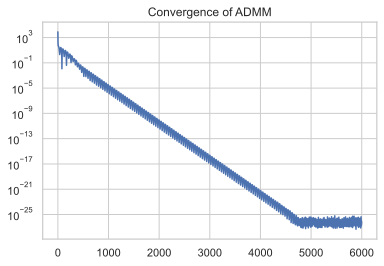

In [11]:
fig, ax = plt.subplots()
diff = jnp.square(jnp.diff(states.x, axis=0)).sum(axis=(1, 2))
ax = cast(Axes, ax)
sns.lineplot(diff, ax=ax)
ax.set_title("Convergence of ADMM")
ax.set_yscale("log")
fig

It seems that the algorithm converges pretty well!
We then use it to recover a partition of the original graph:

In [12]:
eigvals, eigvecs = jnp.linalg.eigh(final_state.x)
largest_eigvec = eigvecs[:, -1]
partition = jnp.sign(largest_eigvec)

Our `final_state.x` actually contains mostly values very close to 0 or 1:

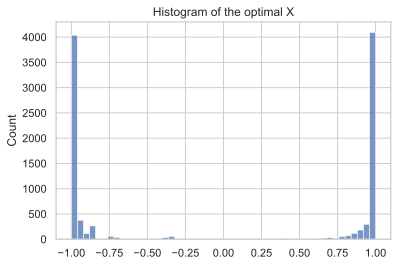

In [13]:
fig, ax = plt.subplots()
ax = cast(Axes, ax)
sns.histplot(final_state.x.flatten(), ax=ax, bins=50)
ax.set_title("Histogram of the optimal X")
fig

Therefore, we are confident that we have found a good partition. To explain why the sign of the eigenvector would reveal the partition, we can observe that our final matrix $X$ is almost rank-1, with one large eigenvector and the rest very small:

In [14]:
eigvals.round(2)

Array([-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  3.24,
       96.76], dtype=float64)

Therefore, by using the eigenvector corresponding to the largest eigenvalue, we can obtain a rank-1 approximation of the matrix. The entries of this eigenvector is also almost on a two-point distribution $\{-{1\over \sqrt{n}},{1\over \sqrt{n}}\}$ (eigenvectors are scale-free, and the ${1\over \sqrt{n}}$ factor comes from normalization):

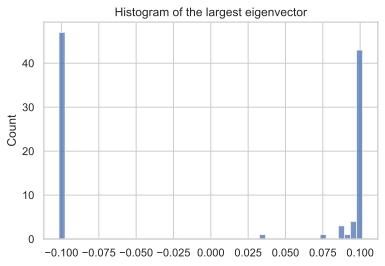

In [15]:
fig, ax = plt.subplots()
ax = cast(Axes, ax)
sns.histplot(largest_eigvec.flatten(), ax=ax, bins=50)
ax.set_title("Histogram of the largest eigenvector")
fig

Therefore, we use a sign function to approximate it on $\{-1,1\}^n$.

In [16]:
print(f"Partition 1: {[i for i, p in enumerate(partition) if p > 0]}")
print(f"Partition 2: {[i for i, p in enumerate(partition) if p < 0]}")

Partition 1: [1, 3, 5, 7, 8, 9, 10, 13, 15, 16, 17, 19, 21, 23, 24, 25, 29, 30, 31, 36, 37, 38, 40, 41, 43, 52, 53, 54, 55, 57, 60, 66, 67, 68, 72, 76, 77, 78, 79, 80, 82, 84, 87, 88, 90, 91, 92, 93, 94, 96, 97, 98, 99]
Partition 2: [0, 2, 4, 6, 11, 12, 14, 18, 20, 22, 26, 27, 28, 32, 33, 34, 35, 39, 42, 44, 45, 46, 47, 48, 49, 50, 51, 56, 58, 59, 61, 62, 63, 64, 65, 69, 70, 71, 73, 74, 75, 81, 83, 85, 86, 89, 95]


Finally, we permute the original matrix to match the partition and visualize.

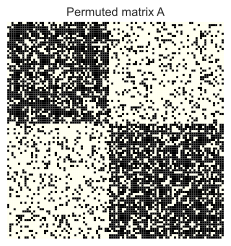

In [17]:
perm = jnp.argsort(partition)
permuted_a = cur_partition.a[perm][:, perm]
fig = visualize_matrix(permuted_a, title="Permuted matrix A")
fig